# **White Male Effect - Understanding America Study**
## Ekim Luo
*Last Updated: October 12, 2021*

# **Data**
- [Understanding America Study](https://uasdata.usc.edu/index.php) COVID-19 National Survey Data, Center for Economic and Social Research, University of Southern California
    - Original data: March 10, 2020 - July 21, 2021 (29 waves)
    - My data: April 1, 2020 - July 21, 2021 (28 waves)

# **Setting up**

In [1]:
# version check
import sys
sys.version

'3.8.8 (default, Apr 13 2021, 19:58:26) \n[GCC 7.3.0]'

In [1]:
# import packages.
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt # graphing
import matplotlib.patches as mpatches 
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.lines import Line2D
import matplotlib.ticker as plticker # force display all x-axis labels 
import seaborn as sns 

In [57]:
# import uas data
# wave 1-10
df1 = pd.read_csv('/home/ekim/RESEARCH/WME_2021/covidpanel_us_csv_jul_21_2021/covidpanel_us_csv_jul_21_2021wv1to10.csv', low_memory = False)
df1 = df1[df1['wave']!=1] # drop wave 1 (pilot data)
# wave 11 - 20
df2 = pd.read_csv('/home/ekim/RESEARCH/WME_2021/covidpanel_us_csv_jul_21_2021/covidpanel_us_csv_jul_21_2021wv11to20.csv', low_memory=False)
# wave 21 - 29
df3 = pd.read_csv('/home/ekim/RESEARCH/WME_2021/covidpanel_us_csv_jul_21_2021/covidpanel_us_csv_jul_21_2021wv21to29.csv', low_memory=False)

In [58]:
# subset data to include relevant variables
cols_to_keep = ['uasid','wave','covid_diagnosed','gender', 'race','age','hhincome','education','cr022a','cr022b','jobs_dayswfh','hhmembernumber','prisk_die']
df1 = df1[cols_to_keep]
df2 = df2[cols_to_keep]
df3 = df3[cols_to_keep]

In [59]:
# concatenate data and preview a few lines
df = pd.concat([df1,df2])
df = pd.concat([df, df3])
print('Full data has the same number of columns as separate data files: ',df1.shape[1]==df.shape[1])
print('Full data has the sum number of rows as separate data files: ',df1.shape[0]+df2.shape[0]+df3.shape[0]==df.shape[0])

Full data has the same number of columns as separate data files:  True
Full data has the sum number of rows as separate data files:  True


In [60]:
# preview data
df.head(5)

,uasid,wave,covid_diagnosed,gender,race,age,hhincome,education,cr022a,cr022b,jobs_dayswfh,hhmembernumber,prisk_die
6932,140100007,2,2.0,1.0,1.0,36.0,15.0,14.0,NaN,NaN,5.0,3.0,1.0
6933,140100035,2,2.0,1.0,1.0,44.0,15.0,11.0,NaN,NaN,5.0,3.0,80.0
6934,140100038,2,2.0,1.0,1.0,30.0,13.0,9.0,NaN,NaN,0.0,4.0,4.7
6935,140100041,2,2.0,1.0,1.0,70.0,13.0,10.0,NaN,NaN,NaN,1.0,1.8
6936,140100047,2,2.0,0.0,1.0,59.0,12.0,13.0,NaN,NaN,0.0,0.0,80.0


# **Cleaning data**

In [61]:
# count the total n of unique individuals before cleaning
len(df['uasid'].unique())

8368

In [62]:
# only include participants that answered "no" to having been diagnosed with covid.
df = df[df['covid_diagnosed'] == 2] 

# **Scoring data**

## **group column**
- White men, White women, non-White men, non-White women

In [63]:
group = [] # create empty list for appending group values 

for i in df[['gender', 'race']].values.tolist(): # loop through the gender and race columns and append group values
    if i[0] == 1 and i[1] == 1: # white male
        group.append('wm') # append value to list 
    elif i[0] == 1 and i[1] != 1: # non-white male
        group.append('nm')
    elif i[0] == 0 and i[1] == 1: # white female
        group.append('ww')
    elif i[0] == 0 and i[1] != 1: # non-white female
        group.append('nw')
    else:
        group.append('NaN') # if the gender or race cells are empty, write in "NaN"

df['group'] = group # append list as a column named group

In [64]:
df = df.loc[df['group'] != 'NaN'] # eliminate 1 row with a missing gender input (wave 2)

## **Appending columns**
- `group2`: White men (1) v. others (0)
- `race2`: Whites (1) v. others (0)

In [66]:
# White men v. others
df['group2'] = 0 # others
df.loc[lambda df: df['group'] == 'wm',['group2']] = 1 # wm

In [67]:
# Whites v. others
df['race2'] = 0 # others
df.loc[lambda df: df['race'] == 1,['race2']] = 1 # white

# **Describing data**

In [68]:
# sample size
# count the total n of unique individuals after cleaning
df['uasid'].nunique()

8339

In [69]:
# attrition
# N indiviuals per wave divided by N sample size
df['wave'].value_counts(sort = False)/len(df['uasid'].unique())

2     0.647680
3     0.743734
4     0.758724
5     0.757285
6     0.757525
7     0.749251
8     0.716753
9     0.739657
10    0.750809
11    0.733901
12    0.738218
13    0.740496
14    0.721070
15    0.718312
16    0.728625
17    0.734980
18    0.712675
19    0.707039
20    0.708478
21    0.706080
22    0.719751
23    0.726586
24    0.744214
25    0.727545
26    0.714834
27    0.712196
28    0.702842
29    0.689291
Name: wave, dtype: float64

In [70]:
# count unique individuals by group
df['boolean'] = df['uasid'] .duplicated() # create new column "boolean" with T/F values based on the duplication of uasid
print(df.loc[df['boolean'] == False,'group'].value_counts()) # count rows with F values by group

ww    3709
wm    2705
nw    1232
nm     693
Name: group, dtype: int64


### **Summary statistics**
- age (`age`)
- household income (`hhincome`)
- education (`education`)
- hospitalized how many family or close friends (`cr022a`)
- died how many family or close friends (`cr022b`)
- N days in the past seven worked from home (`jobs_dayswfh`)
- household size (`hhmembernumber`)

First, extract unique individuals from the DataFrame, then calculate summary statistics based on unique individuals. Do this by creating a separate DataFrame that contains the first instance of each unique individual using `drop_duplicates()`.

In [71]:
# create a copy of df
df_unique = df.copy()

In [72]:
# drop duplicates
df_unique.drop_duplicates(subset = 'uasid', inplace = True)
print('There are a total of {0} unique individuals in the new DataFrame.'.format(df_unique.shape[0]))

There are a total of 8339 unique individuals in the new DataFrame.


In [73]:
# subset new dataframe to contain only relevant columns
cols_to_keep = ['age','hhincome','education','cr022a','cr022b','jobs_dayswfh','hhmembernumber']
df_unique = df_unique[cols_to_keep]
df_unique.head()

,age,hhincome,education,cr022a,cr022b,jobs_dayswfh,hhmembernumber
6932,36.0,15.0,14.0,NaN,NaN,5.0,3.0
6933,44.0,15.0,11.0,NaN,NaN,5.0,3.0
6934,30.0,13.0,9.0,NaN,NaN,0.0,4.0
6935,70.0,13.0,10.0,NaN,NaN,NaN,1.0
6936,59.0,12.0,13.0,NaN,NaN,0.0,0.0


In [34]:
# calculate summary descriptives
# note that 50% quantile = median
df_unique.describe()

,age,hhincome,education,cr022a,cr022b,jobs_dayswfh,hhmembernumber
count,8330.000000,8318.000000,8337.000000,2694.000000,2691.000000,4336.000000,8063.000000
mean,49.318848,11.241284,11.313422,0.213808,0.112969,2.472325,1.722064
std,16.315340,4.172439,2.274579,1.385143,1.504844,2.648439,1.449991
min,18.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,9.000000,10.000000,0.000000,0.000000,0.000000,1.000000
50%,49.000000,13.000000,11.000000,0.000000,0.000000,1.000000,1.000000
75%,62.000000,15.000000,13.000000,0.000000,0.000000,5.000000,3.000000
max,110.000000,16.000000,16.000000,50.000000,67.000000,7.000000,11.000000


### **Calculating descriptives for COVID-19 mortality risk perceptions by group**

In [74]:
# calculate mean and SD of risk perception by group (death)
print('\n\nmean',df.groupby('group')['prisk_die'].mean())
print('\n\nstd',df.groupby('group')['prisk_die'].std())
print('\n\nssem',df.groupby('group')['prisk_die'].sem())
print('\n\nssem',df.groupby('group')['prisk_die'].sem())



mean group
nm    17.142155
nw    18.320878
wm    14.886746
ww    17.589641
Name: prisk_die, dtype: float64


std group
nm    23.784374
nw    24.217223
wm    23.739914
ww    24.401135
Name: prisk_die, dtype: float64


ssem group
nm    0.204130
nw    0.159104
wm    0.100226
ww    0.089103
Name: prisk_die, dtype: float64


ssem group
nm    0.204130
nw    0.159104
wm    0.100226
ww    0.089103
Name: prisk_die, dtype: float64


# **Plotting risk perceptions over time**


## **Calculate descriptive statistics by group across waves**
- means over time
- SDs associated with means over time
- SE of means over time
- CIs at 95% level

In [75]:
# group dataframe by group and wave
# calculate mean, std and sem over time
# save dataframe as df_plot
df_stats = df[['prisk_die','group','wave']].groupby(['group','wave']).agg(['mean','std','sem']).reset_index()
df_stats

group wave  prisk_die                     
                     mean        std       sem
0      nm    2  23.425463  26.742024  1.286626
1      nm    3  21.317304  25.284932  1.134184
2      nm    4  20.731915  24.297264  1.068592
3      nm    5  18.443301  23.760176  1.046998
4      nm    6  20.045192  25.118891  1.101536
..    ...  ...        ...        ...       ...
107    ww   25  14.219053  22.172308  0.424822
108    ww   26  12.840802  21.123446  0.410959
109    ww   27  11.966363  20.736768  0.404279
110    ww   28  11.737437  20.512103  0.403597
111    ww   29  11.262692  20.288274  0.402479

[112 rows x 5 columns]

In [76]:
# calculate CI at 95% level

# get square rooted sample sizes for each group per wave
sample_group_wave = np.sqrt(df.groupby(['wave','group']).size().to_numpy())
# get means for each group per wave
mean_group_wave = df_stats['prisk_die']['mean'].to_numpy()
# get stds for each group per wave
std_group_wave = df_stats['prisk_die']['std'].to_numpy()
# get CIs
ci_upper = mean_group_wave+1.96*std_group_wave/sample_group_wave
ci_lower = mean_group_wave-1.96*std_group_wave/sample_group_wave

In [77]:
# append CIs to df_stats
df_stats['ci_upper']=pd.Series(ci_upper)
df_stats['ci_lower']=pd.Series(ci_lower)
df_stats

group wave  prisk_die                        ci_upper   ci_lower
                     mean        std       sem                      
0      nm    2  23.425463  26.742024  1.286626  25.944337  20.906589
1      nm    3  21.317304  25.284932  1.134184  23.173283  19.461325
2      nm    4  20.731915  24.297264  1.068592  21.832006  19.631824
3      nm    5  18.443301  23.760176  1.046998  19.397691  17.488911
4      nm    6  20.045192  25.118891  1.101536  22.251377  17.839008
..    ...  ...        ...        ...       ...        ...        ...
107    ww   25  14.219053  22.172308  0.424822  15.067422  13.370683
108    ww   26  12.840802  21.123446  0.410959  14.758711  10.922894
109    ww   27  11.966363  20.736768  0.404279  13.398878  10.533848
110    ww   28  11.737437  20.512103  0.403597  12.659046  10.815828
111    ww   29  11.262692  20.288274  0.402479  12.046477  10.478907

[112 rows x 7 columns]

In [78]:
# subset descriptive statistics by group
# 1 = mean, 2 = std, 3 = sem, 4 = ci_upper, 5 = ci_lower
df_stats_wm = df_stats[df_stats['group'] == 'wm'].to_numpy()[:,2:]
df_stats_ww = df_stats[df_stats['group'] == 'ww'].to_numpy()[:,2:]
df_stats_nm = df_stats[df_stats['group'] == 'nm'].to_numpy()[:,2:]
df_stats_nw = df_stats[df_stats['group'] == 'nw'].to_numpy()[:,2:]

df_stats_wm

array([[22.787820512820506, 26.645705663554153, 0.6158490900055494,
        25.149543017811528, 20.426098007829484],
       [19.55311004784689, 25.595822316349093, 0.5598812758846103,
        21.273851794469554, 17.832368301224225],
       [18.598578199052145, 25.3671839899914, 0.5522440320111927,
        19.707575020843237, 17.489581377261054],
       [17.508784425451108, 24.663420628463076, 0.5374327481046156,
        18.434477068444178, 16.583091782458037],
       [17.115882917466404, 24.85969659457997, 0.5445615410261408,
        19.310346790852876, 14.921419044079933],
       [16.263540163540124, 24.250096656429978, 0.5318464066012111,
        17.882424840486113, 14.644655486594136],
       [16.506367804381032, 24.794138664848308, 0.5596143931701199,
        17.583898430620668, 15.428837178141395],
       [16.54367366878353, 24.886666233035918, 0.5500571343928714,
        17.475526895227432, 15.61182044233963],
       [16.429448742746597, 24.898203942074925, 0.5475108786626468,
  

In [79]:
# 27 waves total (2-28)

nWaves =  29 # NEED TO MANUALLY UPDATE PER WAVE 

# define wave range and group values
xWave = range(1,nWaves+1) 
yGroup = ['wm','ww','nm','nw'] 

# create empty matrices to store wave and group values
priskDie =np.zeros((nWaves,4))

# calculate group means and append to empty matrices
for i in xWave: 
 for j in range(4): 
    meanDie = df.loc[(df['wave'] == i) & (df['group'] == yGroup[j]), 'prisk_die'].mean()
    priskDie[i-1,j] = meanDie

for i in range(1, nWaves+1):
  for j in range(len(yGroup)):
    meanDie = df.loc[(df['wave'] == i) & (df['group'] == yGroup[j]), 'prisk_die'].mean()
    priskDie[i-1, j] = meanDie

print(priskDie)
len(priskDie)

[[        nan         nan         nan         nan]
 [22.78782051 26.23386622 23.42546296 22.20635593]
 [19.55311005 23.1413004  21.31730382 22.00130797]
 [18.5985782  21.25046296 20.73191489 21.28025404]
 [17.50878443 20.54657534 18.44330097 20.93047509]
 [17.11588292 19.62976744 20.04519231 19.47571266]
 [16.26354016 19.19269091 18.18271845 19.13050058]
 [16.5063678  19.54401343 17.90649895 19.40183599]
 [16.54367367 19.49985262 18.64990138 19.9056582 ]
 [16.42944874 18.71909091 18.48420039 19.96773823]
 [16.3509172  18.84194383 17.37955466 19.04267292]
 [15.67025692 17.86477024 17.79307536 18.05567503]
 [15.42097561 17.65548221 18.17489879 18.43309942]
 [15.62667004 17.56846442 17.77958333 18.53759124]
 [15.04451158 17.34127225 17.89       19.03837772]
 [14.62306153 17.24731581 17.10698152 18.69892857]
 [14.76268509 17.07942478 17.37657841 18.51627358]
 [15.28078292 17.74831758 16.91670282 18.7361754 ]
 [14.41847328 17.80091778 16.5691974  17.84822785]
 [14.13104693 17.2411922  16.41

29

In [80]:
# check wave range
range(nWaves)

range(0, 29)

In [81]:
# labeling plot

wave_times = ['2020',
'Apr 1 - Apr 28',
'Apr 15 – May 13',
'Apr 29 – May 26',
'May 13 - June 9',
'May 27 - June 23',
'June 10 - Jul 8',
'June 24 - Jul 22',
'July 8 - Aug 5',
'July 22 - Aug 19',
'Aug 5 - Sep 2',
'Aug 19 - Sep 16',
'Sep 2 - Sep 30',
'Sep 16 - Oct 14',
'Sep 30 - Oct 27',
'Oct 14 - Nov 11',
'Oct 28 - Nov 25',
'Nov 11 - Dec 9',
'Nov 25 - Dec 23',
'Dec 9 - Jan 6',
'Dec 23 - Jan 20',
'Jan 6 - Feb 3',
'Jan 20 - Feb 17',
'Feb 2  - Mar 3', 
'Feb 17 - Mar 30',
'Mar 17 - Apr 27',
'Apr 14 - May 25',
'May 12 - Jun 22',
'Jun 9 - Jul 21',
'2021']

In [82]:
# create function for ticks
def format_fn(tick_val, tick_pos):
    if int(tick_val) in range(nWaves+1):
        return wave_times[int(tick_val)]
    else:
        return ''

## **Perceived risk of COVID-19 death**

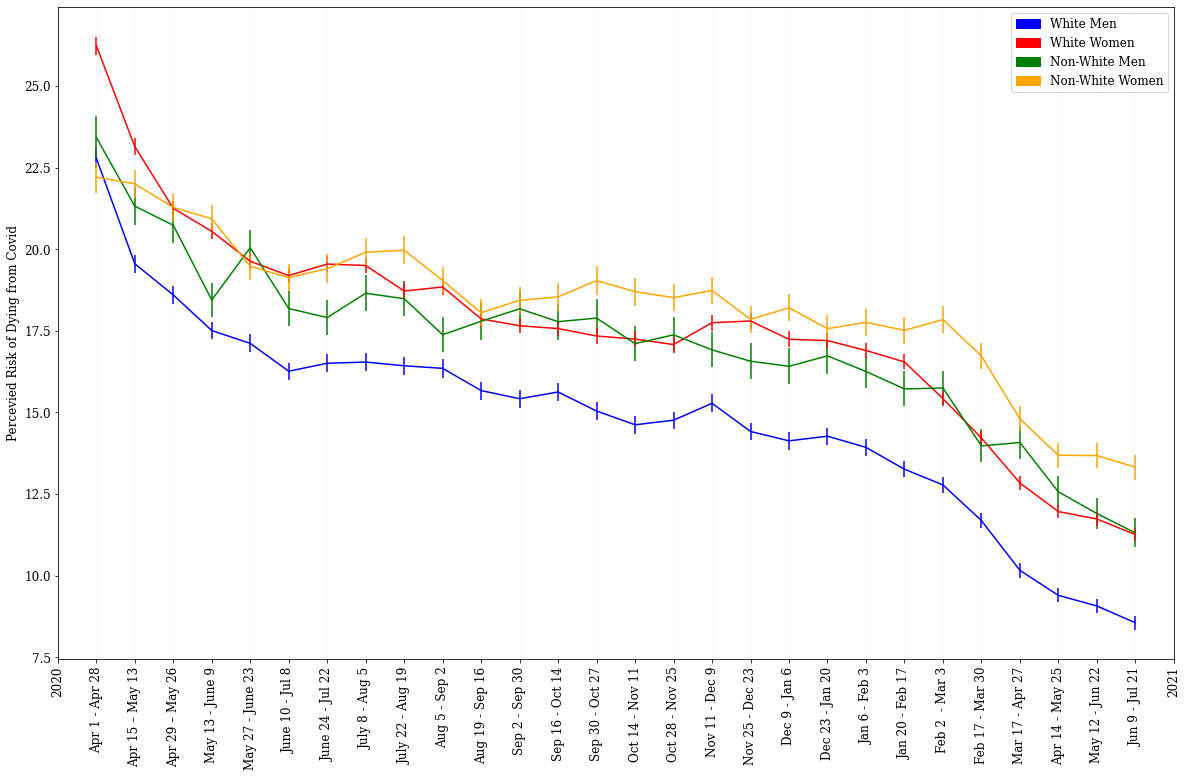

In [83]:
# plot mean perceived risk of COVID-19 mortality over time

ax = plt.subplot(111)
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim((0, 29))

loc = plticker.MultipleLocator(base=1.0) # enforces regular intervals on the x-axis
ax.xaxis.set_major_locator(loc)

ax.plot(priskDie[:,0],color='blue')
ax.plot(priskDie[:,1],color='red')
ax.plot(priskDie[:,2],color='green')
ax.plot(priskDie[:,3],color='orange')

barBlue = mpatches.Patch(color='blue', label='White Men')
barRed = mpatches.Patch(color='red', label='White Women')
barGreen = mpatches.Patch(color='green', label='Non-White Men')
barOrange = mpatches.Patch(color='orange', label='Non-White Women')

plt.legend(handles=[barBlue, barRed, barGreen, barOrange],loc='upper right')
plt.ylabel('Percevied Risk of Dying from Covid')
plt.xticks(rotation=90) # tilt x-axis labels

for i in range(nWaves):
  plt.axvline(x=i,color='red',alpha=0.05,linewidth=0.7)
  plt.plot()

# make errorbars for wm
for wave in range(df_stats_wm.shape[0]):
  m_wm= df_stats_wm[wave,0]
  sem_wm = df_stats_wm[wave,2]
  errorbar_sem_wm = (m_wm-sem_wm/2,m_wm+sem_wm/2)
  plt.vlines(wave+1,errorbar_sem_wm[0],errorbar_sem_wm[1],color='blue')
# make errorbars for nm
for wave in range(df_stats_nm.shape[0]):
  m_nm= df_stats_nm[wave,0]
  sem_nm = df_stats_nm[wave,2]
  errorbar_sem_nm = (m_nm-sem_nm/2,m_nm+sem_nm/2)
  plt.vlines(wave+1,errorbar_sem_nm[0],errorbar_sem_nm[1],color='green')
# make errorbars for ww
for wave in range(df_stats_ww.shape[0]):
  m_ww= df_stats_ww[wave,0]
  sem_ww = df_stats_ww[wave,2]
  errorbar_sem_ww = (m_ww-sem_ww/2,m_ww+sem_ww/2)
  plt.vlines(wave+1,errorbar_sem_ww[0],errorbar_sem_ww[1],color='red')
# make errorbars for nw
for wave in range(df_stats_nw.shape[0]):
  m_nw= df_stats_nw[wave,0]
  sem_nw = df_stats_nw[wave,2]
  errorbar_sem_nw = (m_nw-sem_nw/2,m_nw+sem_nw/2)
  plt.vlines(wave+1,errorbar_sem_nw[0],errorbar_sem_nw[1],color='orange')

plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size':12})
plt.rcParams['figure.figsize'] = [20 , 12] # specify figure size

plt.savefig('plot_errorbars_sem.png',orientation = 'landscape',facecolor='w',dpi=200)
plt.show();



# **Exporting scored data**
- Analyze data in R.

## **Full data**

In [86]:
df.to_csv('uas_cleaned_full.csv') # export processed dataset as a csv file

## **Subset data to include participants who responded to more than 1 wave**

In [84]:
# include only those who responded to more than 1 wave
df_morethan1 = df[df.groupby('uasid').uasid.transform(len) > 1]

In [85]:
# count sample size by group
df_morethan1['boolean'] = df_morethan1['uasid'] .duplicated() # create new column "boolean" with T/F values based on the duplication of uasid
print(df_morethan1.loc[df_morethan1['boolean'] == False,'group'].value_counts()) # count rows with F values by group

ww    3640
wm    2646
nw    1204
nm     679
Name: group, dtype: int64


<ipython-input-85-77fad0e8106b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_morethan1['boolean'] = df_morethan1['uasid'] .duplicated() # create new column "boolean" with T/F values based on the duplication of uasid


In [87]:
# count N of participants who responded to more than 1 wave
df_morethan1['uasid'].nunique()

8169

In [88]:
# export to csv
df_morethan1.to_csv('uas_morethan1wave.csv')

## **Subset data to include participants who only responded to 1 wave**

In [89]:
# include those who responded to 1 wave only
df_only1 = df[df.groupby('uasid').uasid.transform(len) == 1]

In [90]:
# count sample size by group
df_only1['boolean'] = df_only1['uasid'] .duplicated() # create new column "boolean" with T/F values based on the duplication of uasid
print(df_only1.loc[df_only1['boolean'] == False,'group'].value_counts()) # count rows with F values by group

ww    69
wm    59
nw    28
nm    14
Name: group, dtype: int64


<ipython-input-90-d5ee5c4fdaf5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_only1['boolean'] = df_only1['uasid'] .duplicated() # create new column "boolean" with T/F values based on the duplication of uasid


In [91]:
# count N of participants who responded to more than 1 wave
df_only1['uasid'].nunique()

170

In [92]:
# export to csv
df_only1.to_csv('uas_only1wave.csv')

In [93]:
print('There are a total of {0} individuals who responded to at least one wave. Out of these individuals, {1} individuals responded to more than one wave, and {2} individuals responded to only one wave.'.format(df['uasid'].nunique(), df_morethan1['uasid'].nunique(), df_only1['uasid'].nunique()))

There are a total of 8339 individuals who responded to at least one wave. Out of these individuals, 8169 individuals responded to more than one wave, and 170 individuals responded to only one wave.
